In [ ]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("WARNING")


2026-02-12 14:17:24 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.


In [2]:
symbol_rate = 100e9
sampling_rate = 200e9
sps = int(sampling_rate / symbol_rate)


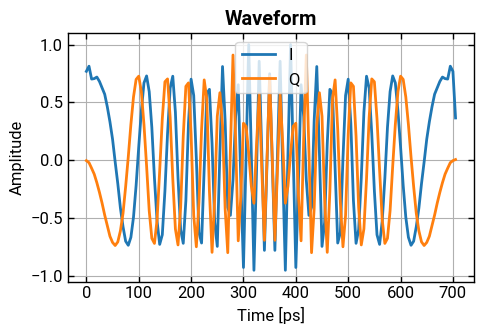

In [40]:
p = Preamble(sequence_type="zc", length=71)
ps = p.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True)


In [41]:
f = SingleCarrierFrame(
    payload_len=80000,
    payload_seed=42,
    payload_mod_scheme="qam",
    payload_mod_order=64,
    preamble=p,
    preamble_gain_db=0.0,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme="qam",
    pilot_mod_order=4,
    pilot_gain_db=0.0,
)


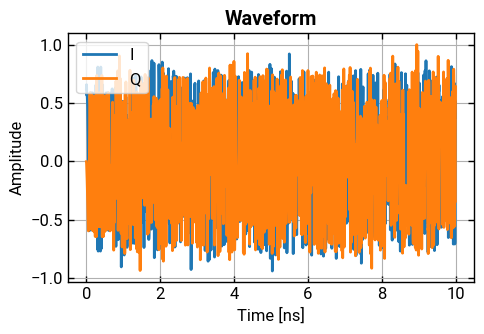

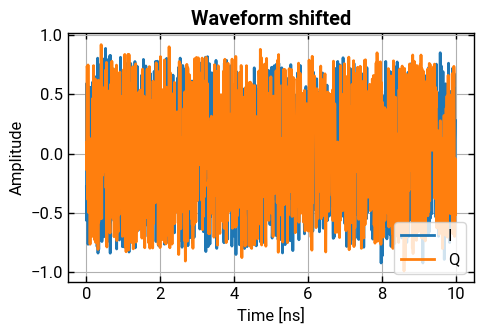

In [42]:
from commstools.backend import get_array_module

fs = f.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_symbols(show=True, num_symbols=1000)

xp = get_array_module(fs.samples)

fs.samples = xp.roll(fs.samples, 10231)

fs.plot_symbols(show=True, title="Waveform shifted", num_symbols=1000)


In [44]:
fs.matched_filter()


Signal(samples=array([-0.51413699-0.00236665j, -0.62463088-0.08738531j,
        0.07341201+0.08732512j, ...,  0.13166103-0.36777764j,
        0.19933451-0.02266182j,  0.18727019+0.32741981j], shape=(177920,)), sampling_rate=200000000000.0, symbol_rate=100000000000.0, modulation_scheme=None, modulation_order=None, source_bits=None, source_symbols=None, pulse_shape='rrc', spectral_domain='BASEBAND', physical_domain='DIG', center_frequency=0, digital_frequency_offset=0, filter_span=10, rrc_rolloff=0.35, rc_rolloff=0.35, gaussian_bt=0.3, smoothrect_bt=1.0, signal_info=SignalInfo(signal_type='single_carrier_frame', preamble_len=71, preamble_type='zc', preamble_kwargs={}, payload_len=80000, payload_mod_scheme='qam', payload_mod_order=64, pilot_count=8889, pilot_pattern='comb', pilot_period=10, pilot_block_len=1, pilot_mod_scheme='qam', pilot_mod_order=4, guard_len=0, guard_type='zero'))

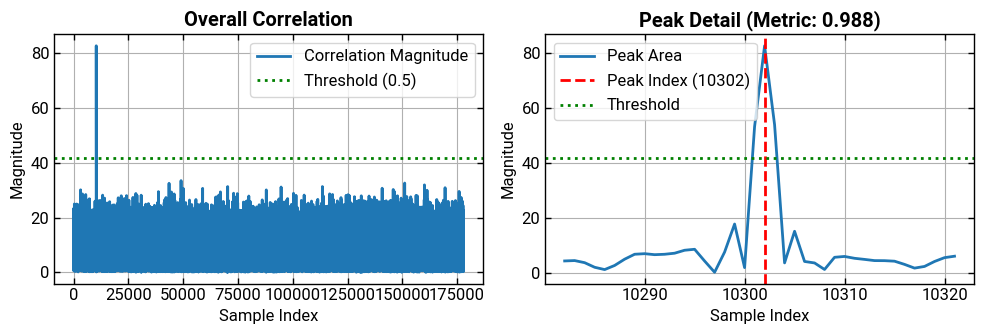

(10231, 0.9883977087588636)


In [45]:
from commstools.sync import detect_frame

print(detect_frame(fs, ps.samples, return_metric=True, debug_plot=True))


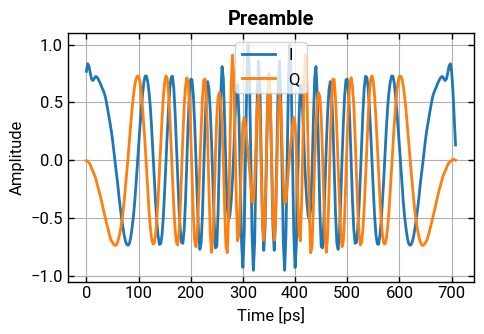

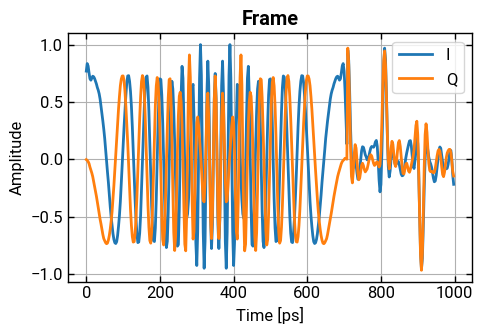

In [92]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("WARNING")


symbol_rate = 100e9
sampling_rate = 400e9
sps = int(sampling_rate / symbol_rate)

p = Preamble(sequence_type="zc", length=71)

f = SingleCarrierFrame(
    payload_len=80000,
    payload_seed=42,
    payload_mod_scheme="qam",
    payload_mod_order=64,
    preamble=p,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme="qam",
    pilot_mod_order=4,
    pilot_gain_db=20.0,
)

ps = p.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True, title="Preamble")

fs = f.to_waveform(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
# fs.plot_symbols(show=True, start_symbol=69, num_symbols=10, title="Frame")
fs.plot_symbols(show=True, num_symbols=100, title="Frame")


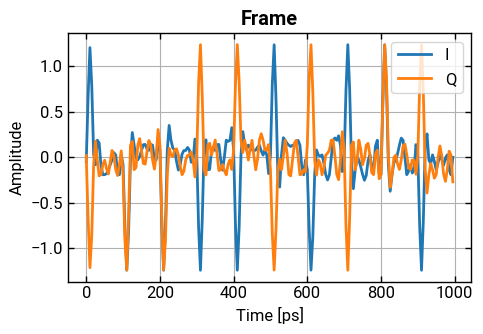

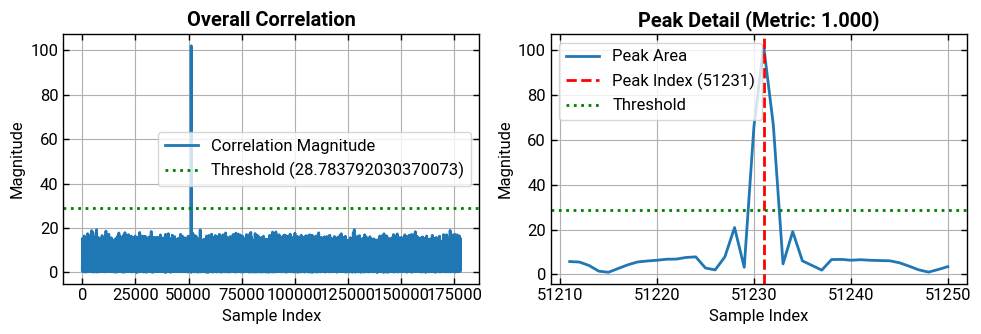

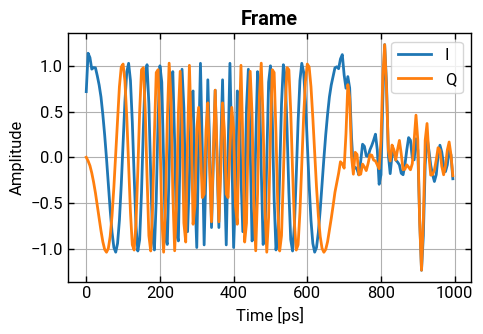

In [112]:
from commstools.backend import get_array_module
from commstools.sync import detect_frame
from commstools.impairments import add_awgn

rxfs = fs.copy()
xp = get_array_module(rxfs.samples)

rxfs.samples = xp.roll(rxfs.samples, 102320)
# rxfs.samples = add_awgn(rxfs.samples, esn0_db=20, sps=sps)

rxfs.resample(sps_out=2)
rxfs.matched_filter()
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")

fix = detect_frame(rxfs, p, return_metric=True, debug_plot=True)

rxfs.samples = xp.roll(rxfs.samples, -fix[0])
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")


In [113]:
rxfs.samples = rxfs.samples[p.num_symbols * rxfs.sps :]


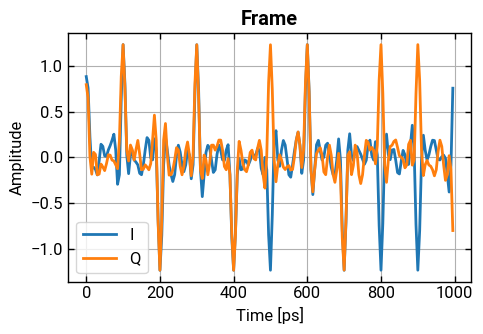

In [114]:
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")


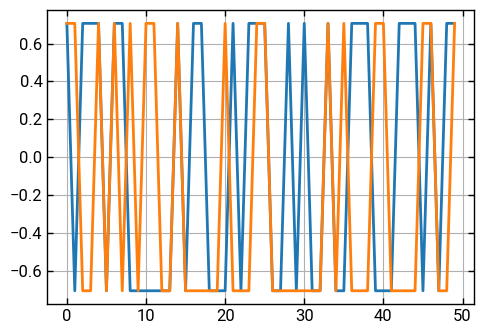

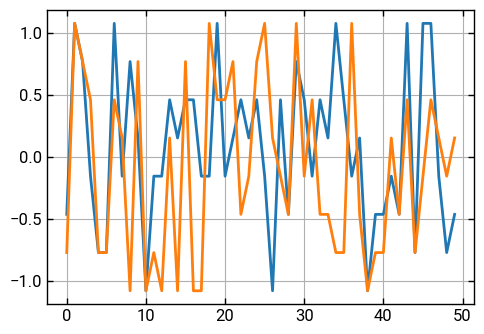

In [115]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(f.pilot_symbols[50:100].get().real)
plt.plot(f.pilot_symbols[50:100].get().imag)
plt.show()

plt.figure()
plt.plot(f.payload_symbols[50:100].get().real)
plt.plot(f.payload_symbols[50:100].get().imag)
plt.show()


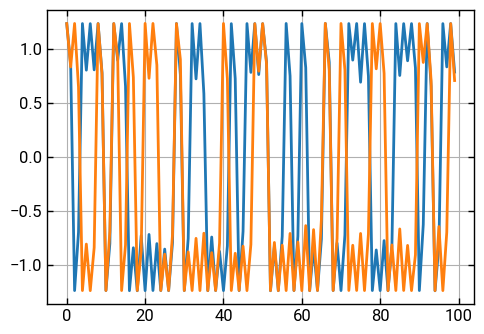

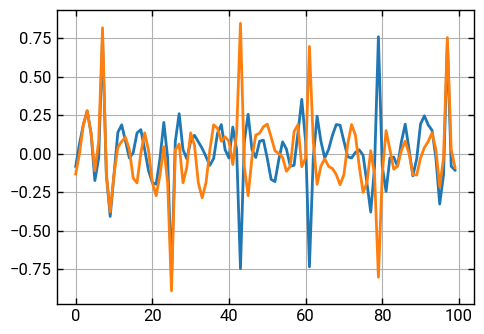

In [116]:
map = f.get_structure_map(unit="samples", sps=rxfs.sps)


plt.figure()
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()

plt.figure()
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()


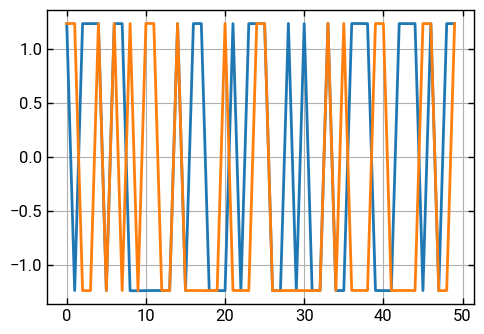

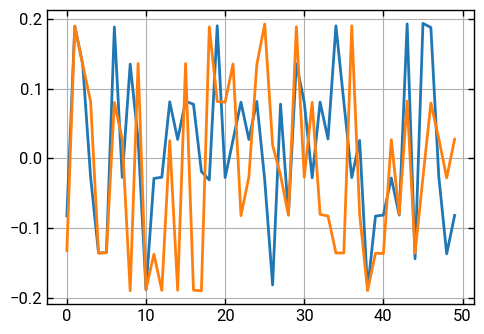

In [117]:
rxfs.downsample_to_symbols(offset=0)
map = f.get_structure_map(unit="samples", sps=rxfs.sps)

plt.figure()
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()

plt.figure()
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()


In [ ]:
xp.var(rxfs.samples[map["pilots"]])


array(3.06508186)

In [119]:
xp.var(rxfs.samples[map["payload"]])


array(0.03080008)

In [120]:
10 * xp.log10(
    xp.var(rxfs.samples[map["pilots"]]) / xp.var(rxfs.samples[map["payload"]])
)


array(19.97890243)